global state 
pools: 

    Omnipool: Omnipool
    ********************************
    tvl cap: inf
    lrna fee: 0%
    asset fee: 0%
    asset pools: (
    
        *HDX*
        asset quantity: 1000000.0
        lrna quantity: 250000.0
        USD price: 25.0
        tvl: 25000000.0
        weight: 250000.0/340000.0 (0.7352941176470589)
        weight cap: 1.0
        total shares: 1000000.0
        protocol shares: 1000000.0
    
        *USD*
        asset quantity: 1000000.0
        lrna quantity: 10000.0
        USD price: 1.0
        tvl: 1000000.0
        weight: 10000.0/340000.0 (0.029411764705882353)
        weight cap: 1.0
        total shares: 1000000.0
        protocol shares: 1000000.0
    
        *DAI*
        asset quantity: 1000000.0
        lrna quantity: 10000.0
        USD price: 1.0
        tvl: 1000000.0
        weight: 10000.0/340000.0 (0.029411764705882353)
        weight cap: 1.0
        total shares: 1000000.0
        protocol shares: 1000000.0
    
        

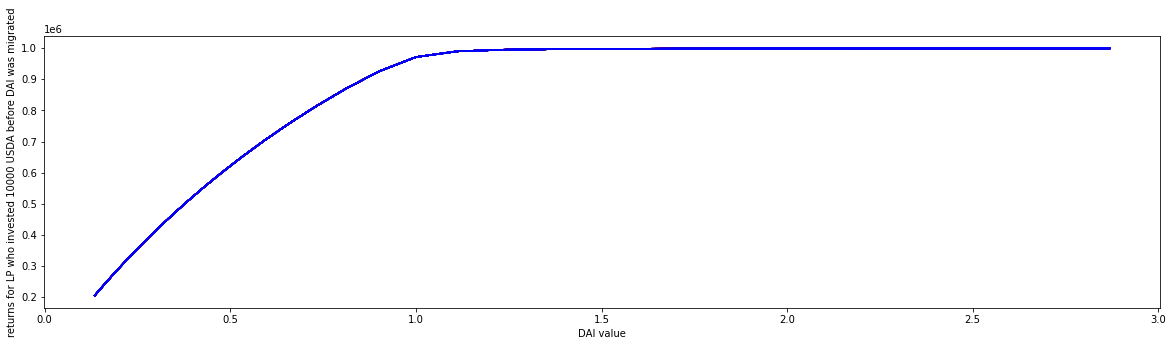

In [31]:
import pandas as pd
import random
from matplotlib import pyplot as plt
import sys
sys.path.append('../..')

from model import run
from model import plot_utils
from model import processing
from model.amm.omnipool_amm import OmnipoolState
from model.amm.stableswap_amm import StableSwapPoolState
from model.amm.agents import Agent
from model.amm.trade_strategies import random_swaps
from model.amm.global_state import GlobalState, swap, add_liquidity, migrate, migrate_lp, create_sub_pool
from model.amm import omnipool_amm as oamm

# same seed, same parameters = same simulation result
random.seed(42)

# set up the state

proto_state = GlobalState(
    pools = {
        "Omnipool": OmnipoolState(
            tokens={
                'HDX': {'liquidity': 1000000, 'LRNA_price': 4},
                'USD': {'liquidity': 1000000, 'LRNA_price': 100},
                'USDA': {'liquidity': 1000000, 'LRNA_price': 100},
                'USDB': {'liquidity': 1000000, 'LRNA_price': 100},
                'USDC': {'liquidity': 1000000, 'LRNA_price': 100},
                'DAI': {'liquidity': 1000000, 'LRNA_price': 100},
                'R1': {'liquidity': 1000000, 'LRNA_price': 50},
                'R2': {'liquidity': 3000000, 'LRNA_price': 150},
            },
            lrna_fee=0,  # these can also be FeeMechanism type
            asset_fee=0
        )
    },
    agents = {
        'Trader': Agent(
            holdings={'HDX': 10000, 'USD': 10000, 'R1': 10000, 'R2': 10000},
        ),
        'LP': Agent(
            holdings={'DAI': 1000000}, 
        )
    }
)
initial_state = create_sub_pool(
    old_state=proto_state,
    pool_id='Omnipool',
    sub_pool_id='Stableswap',
    tkns_migrate=['USDA', 'USDB', 'USDC'], 
    amplification=10,
    trade_fee=0.003
)

print(initial_state)
dai_values = [
    .9 ** i for i in range(-10, 20)
]
amps = [i**2 for i in range(2, 101)]


# print(lp)
results = {}
for a in amps:
    results[a] = []
    test_state.pools['Omnipool'].sub_pools['Stableswap'].amplification = a
    for v in dai_values:
        # test_state.pools['Omnipool'].liquidity['DAI'] = initial_state.pools['Omnipool'].liquidity['DAI'] * v
        test_state = initial_state.copy()
        test_state.pools['Omnipool'].lrna['DAI'] = initial_state.pools['Omnipool'].lrna['DAI'] * v
        test_state = add_liquidity(
            old_state=test_state,
            pool_id='Omnipool',
            agent_id='LP',
            tkn_add='DAI',
            quantity=initial_state.agents['LP'].holdings['DAI']
        )
        lp = test_state.agents['LP']
        result_state, result_lp = test_state.pools['Omnipool'].execute_migrate_asset(
            sub_pool_id='Stableswap',
            tkn_migrate='DAI'
        ).execute_migrate_lp(
            agent=lp.copy(),
            sub_pool_id='Stableswap',
            tkn_migrate='DAI'
        )
        # print(result_lp.holdings['Stableswap'])
        # print(result_state)
        
        # break
        results[a].append(
            oamm.remove_liquidity(
                old_state=result_state,
                old_agent=result_lp,
                tkn_remove='USDA',
                quantity=result_lp.holdings['Stableswap']
            )[1].holdings['USDA']
        )
    # break

# print(results)
colors = plot_utils.color_gradient(len(results.keys()))
plt.figure(figsize=(20, 5))
for i, amp in enumerate(results):
    plt.xlabel('DAI value')
    plt.ylabel('returns for LP who invested 10000 USDA before DAI was migrated')
    plt.plot(dai_values, results[amp], color=colors[i])

In [25]:
print(colors)


['#ff0000', '#fc0002', '#f90005', '#f70007', '#f4000a', '#f1000d', '#ef000f', '#ec0012', '#ea0014', '#e70017', '#e4001a', '#e2001c', '#df001f', '#dd0021', '#da0024', '#d70027', '#d50029', '#d2002c', '#d0002e', '#cd0031', '#ca0034', '#c80036', '#c50039', '#c3003b', '#c0003e', '#bd0041', '#bb0043', '#b80046', '#b60048', '#b3004b', '#b0004e', '#ae0050', '#ab0053', '#a90055', '#a60058', '#a3005b', '#a1005d', '#9e0060', '#9c0062', '#990065', '#960068', '#94006a', '#91006d', '#8f006f', '#8c0072', '#890075', '#870077', '#84007a', '#82007c', '#7f007f', '#7c0082', '#7a0084', '#770087', '#750089', '#72008c', '#6f008f', '#6d0091', '#6a0094', '#680096', '#650099', '#62009c', '#60009e', '#5d00a1', '#5b00a3', '#5800a6', '#5500a9', '#5300ab', '#5000ae', '#4e00b0', '#4b00b3', '#4800b6', '#4600b8', '#4300bb', '#4100bd', '#3e00c0', '#3b00c3', '#3900c5', '#3600c8', '#3400ca', '#3100cd', '#2e00d0', '#2c00d2', '#2900d5', '#2700d7', '#2400da', '#2100dd', '#1f00df', '#1c00e2', '#1a00e4', '#1700e7', '#1400ea'

In [26]:
results.keys()

dict_keys([4, 9, 16, 25, 36, 49, 64, 81, 100, 121, 144, 169, 196, 225, 256, 289, 324, 361, 400, 441, 484, 529, 576, 625, 676, 729, 784, 841, 900, 961, 1024, 1089, 1156, 1225, 1296, 1369, 1444, 1521, 1600, 1681, 1764, 1849, 1936, 2025, 2116, 2209, 2304, 2401, 2500, 2601, 2704, 2809, 2916, 3025, 3136, 3249, 3364, 3481, 3600, 3721, 3844, 3969, 4096, 4225, 4356, 4489, 4624, 4761, 4900, 5041, 5184, 5329, 5476, 5625, 5776, 5929, 6084, 6241, 6400, 6561, 6724, 6889, 7056, 7225, 7396, 7569, 7744, 7921, 8100, 8281, 8464, 8649, 8836, 9025, 9216, 9409, 9604, 9801])